# Прогнозирование временных рядов на карте: Знакомство с данными и агрегация

In [51]:
%pylab inline
from collections import defaultdict
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Загружаем данные за май 2016

In [31]:
data = pd.read_csv('yellow_tripdata_2016-05.csv')

In [3]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


Текущий размер данных

In [4]:
data.shape

(11836853, 19)

Фильтруем поездки:
  1. У которых начало не попало в границы Нью Йорка
  2. С нулевым расстоянием поездки по счётчику
  3. С нулевым количеством пассажиров
  4. С нулевой длительностью
  
Оставляем только колонки нужные для работы.

In [32]:
data = data[
    (-74.25559 <= data.pickup_longitude) & (data.pickup_longitude <= -73.70001) &
    (40.49612 <= data.pickup_latitude) & (data.pickup_latitude <= 40.91553) & 
    (data.trip_distance > 0) & (data.passenger_count > 0) &
    (data.tpep_pickup_datetime < data.tpep_dropoff_datetime)
][['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude']]

Текущий размер данных

In [6]:
data.shape

(11626521, 3)

Загружаем список регионов

In [20]:
region = pd.read_csv('regions.csv', delimiter=';')

In [21]:
region.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


Определяем регион откуда была начата поездка.

In [10]:
data['region'] = [
    region[
        (region.west <= _[0]) &
        (region.east >= _[0]) &
        (region.south <= _[1]) &
        (region.north >= _[1])
    ].region.values[0] for _ in data[['pickup_longitude', 'pickup_latitude']].values
]

Округляем до часов время начала поездки и создаём колонку hid с идентификатором часа поездки по порядку

In [33]:
data['hour'] = data['tpep_pickup_datetime'].apply(lambda tpep_pickup_datetime: tpep_pickup_datetime[:-5] + '00:00')

In [34]:
hours = {item: index for index, item in enumerate(sorted(data.hour.unique()))}
data['hid'] = data['hour'].apply(lambda hour: hours[hour])

In [23]:
data = data[['hour', 'region', 'hid']]

In [24]:
data.head()

,hour,region,hid
0,2016-05-01 00:00:00,1233,0
1,2016-05-01 00:00:00,1180,0
2,2016-05-01 00:00:00,1180,0
3,2016-05-01 00:00:00,1173,0
4,2016-05-01 00:00:00,1130,0


In [36]:
data.to_csv('tmp.csv')

In [3]:
from scipy.stats import binned_statistic_2d
import pandas as pd
data = pd.read_csv('tmp.csv', index_col = 0)

In [4]:
data.head()

,hour,region,hid
0,2016-05-01 00:00:00,1233,0
1,2016-05-01 00:00:00,1180,0
2,2016-05-01 00:00:00,1180,0
3,2016-05-01 00:00:00,1173,0
4,2016-05-01 00:00:00,1130,0


Считаем статистику поездок из каждого региона в каждый час

In [5]:
bin_regions = range(1, 2502)
bin_hids = range(745)
result = binned_statistic_2d(data.region, data.hid, None, statistic = 'count', bins=[bin_regions, bin_hids])

In [26]:
result.statistic[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Координаты Empire State Building -73.9721 40.7459 Выделим соответствующий регион и построим график числа поездок по часам.

In [22]:
region[(region.west <= -73.9721) & (region.east >= -73.9721) & (region.south <= 40.7459) & (region.north >= 40.7459)]

,region,west,east,south,north
1279,1280,-73.9778,-73.966688,40.739378,40.747766


In [68]:
ESB = pd.DataFrame(zip(result.statistic[1279], sorted(hours)), columns=['count', 'hour'])

In [70]:
ESB.head()

,count,hour
0,248.0,2016-05-01 00:00:00
1,120.0,2016-05-01 01:00:00
2,94.0,2016-05-01 02:00:00
3,87.0,2016-05-01 03:00:00
4,58.0,2016-05-01 04:00:00


In [77]:
import matplotlib.pyplot as plt

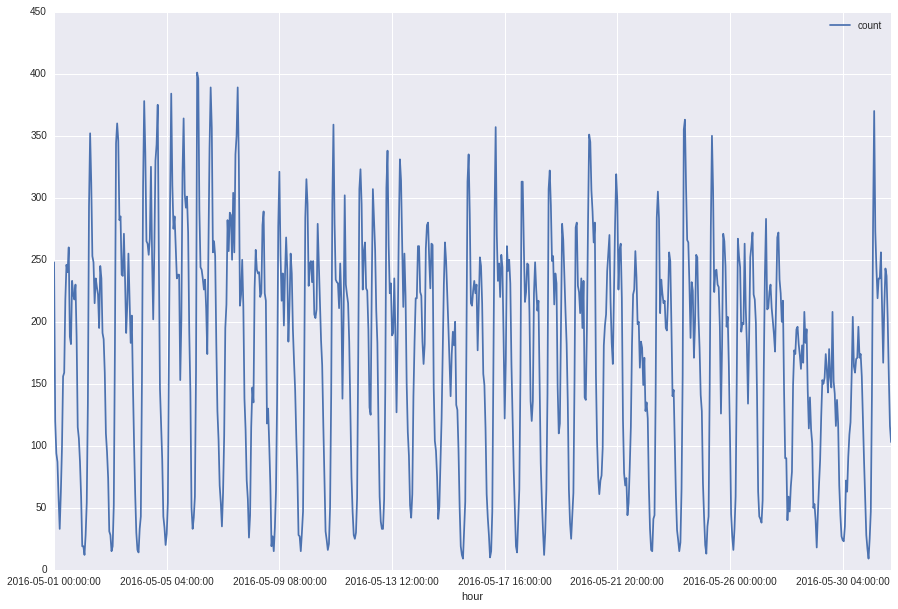

In [78]:
plt.figure(figsize(15,10))
ESB.plot(x='hour')

Посчитаем сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [80]:
count = 0
for item in result.statistic:
    for _ in item:
        if _ == 0:
            count += 1
print "Пар час-ячейка, для которых не было совершено ни одной поездки {}".format(count)

Пар час-ячейка, для которых не было совершено ни одной поездки 1718238
